In [1]:
### LIBRARY ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from mm_functions_optSim import *
from scipy import inf
from scipy.optimize import minimize, Bounds, LinearConstraint

from multiprocess import Pool
from functools import partial
import statsmodels.api as sm

In [2]:
planting(456)

#### *Load Data*

In [3]:
cyto_data = pd.read_csv("~/Documents/Computation/Y3/data/raw/flow_prop_canonical.csv")

##### *Process Data: All patients*

In [4]:
cyto_sPos = cyto_data[cyto_data.Spike == "S+"]

# state names
celltype_list = ['Trans/Naive', 'IgM+IgD+CD27+', 'IgM+IgD-CD27+','DN', 'switched_mem', 'plasma']

# get them all together for residuals
 # extract the sampled time points
timepoint_list_allP = np.sort(cyto_sPos.Timepoint.unique())
    
# transform into state count
cyto = formatCount(cyto_sPos, timepoint_list_allP, 'Timepoint', 'cell_type', timemarker='d', isotype_list=celltype_list, proportion_col_name='value')

# transform into nump array for calculations
cyto = cyto.to_numpy()

In [40]:
def eqTin_donors(df, donor_col = "PatientID", timepoint_col = "Timepoint", state_col_name = "cell_type", state_list = celltype_list, iscount=True, proportion_col_name = None):
    M_donors = {}
    N_donors = {}
    T_donors = {}
    u_donors = {}

    donors = df[donor_col].unique()
    timeCourse = {}

    for d in donors:
    
        # donor filter
        df_donor = df[df[donor_col] == d]
    
        # extract the sampled time points
        timepoint_list = np.sort(df_donor[timepoint_col].unique())
        timeCourse[d] = timepoint_list.shape[0] 
    
        # transform into state count
        df_donor = formatCount(df_donor, timepoint_list, timepoint_col, state_col_name, timemarker='d', isotype_list=state_list, proportion_col_name=proportion_col_name)

        # transform into nump array for calculations
        donor = df_donor.to_numpy()
    
        N, M, T, k = eqTin(donor, proportion=iscount)
    
        M_donors[d] = M
        N_donors[d] = N
        T_donors[d] = T
        u_donors[d] = np.diff(timepoint_list)
    return M_donors, N_donors, T_donors, u_donors

M_donors, N_donors, T_donors, u_donors = eqTin_donors(cyto_sPos, iscount=False, proportion_col_name='value')

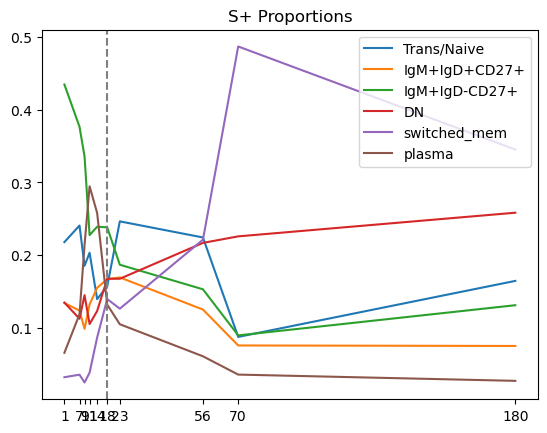

In [6]:
for i in range(6):
    plt.plot(timepoint_list,cyto[i,:], label = celltype_list[i])
    plt.xticks(timepoint_list)
plt.axvline(x=18, linestyle = '--', color = 'grey')
plt.title('S+ Proportions')
plt.legend()
plt.show()

##### *Q Template & Functions*

In [7]:
Q_template = np.array([[1.,2.,3.,4.,5.,6.], # no returning to Naive state
                      [0,2.,3.,4.,5.,6.],
                      [0,2.,3.,4.,5.,6.],
                      [0,2.,3.,4.,5.,6.],  
                      [0,0,0,4.,5.,6.],  # switched memory cannot become M_mem or IgD- as they are both IgM and this is switched
                      [0,0,0,0,0,0]]) # absorbing state = plasma

In [8]:
def genTheta(k, ub = 2e-1, **kwargs):
    # create starting intensity trans. mat
    Q_0 = np.zeros((k,k))

    for i in range(5):
        for j in range(1,6):
            Q_0[i,j] = rand.uniform(1e-12,ub)
        
        # C_mem structural zeros
        if i == 4:
            Q_0[i,1:3] = 0.
            
        # sum our row
        sum_q_ij = sum(Q_0[i,])
    
        # assign ii based on the constraint that the row must equal 0
        Q_0[i,i] = -sum_q_ij  
        
    theta_0 = Q_0[np.nonzero(Q_0[:,:-1])]
    result = theta_0

    return result

def genTheta_ingress(k, ub = 2e-1, **kwargs):
    # create starting intensity trans. mat
    Q_0 = np.zeros((k,k))

    for i in range(5):
        for j in range(1,6):
            Q_0[i,j] = rand.uniform(1e-12,ub)
        
        # C_mem structural zeros
        if i == 4:
            Q_0[i,1:3] = 0
            
        # sum our row
        sum_q_ij = sum(Q_0[i,])
    
        # assign ii based on the constraint that the row must equal 0
        Q_0[i,i] = -sum_q_ij  
    theta_0 = Q_0[np.nonzero(Q_0[:,:-1])]
    
    b0 = rand.uniform(1e-12,1)
    
    result = np.append(theta_0,b0)

    return result

def genTheta_baseline(k, ub = 2e-1, **kwargs):
    # create starting intensity trans. mat
    Q_0 = np.zeros((k,k))

    for i in range(5):
        for j in range(1,6):
            Q_0[i,j] = rand.uniform(1e-12,ub)
            
        # C_mem structural zeros
        if i == 4:
            Q_0[i,1:3] = 0
        
        # sum our row
        sum_q_ij = sum(Q_0[i,])
    
        # assign ii based on the constraint that the row must equal 0
        Q_0[i,i] = -sum_q_ij  
    theta_0 = Q_0[np.nonzero(Q_0[:,:-1])]
    
    b0 = [rand.uniform(-1,1) for i in range(k)]
    
    result = np.append(theta_0,b0)

    return result

## Spike Positive

In [9]:
# set param
xterm = 1e-15
gterm = 1e-15
max_iter = 1e5
numCores = 15
mc_iter = 25
n_param = len(np.nonzero(Q_template[:,:-1])[0])

Regular bounds &

In [10]:
q_lb = np.zeros(n_param)
q_ub = np.zeros(n_param)

q_diag = np.zeros((k-1))

q_diag[-1] = 18
for n in range((k-2)):
    q_diag[n] = (k-1) * n
    
for n in range(n_param):
    if n in q_diag:
        q_lb[n] = -inf
        q_ub[n] = 0
    else:
        q_lb[n] = 0 
        q_ub[n] = inf

reg_bounds = Bounds(q_lb, q_ub)

row_eq = np.zeros((((k-1),n_param)))

row_eq[0,0:5] = 1
row_eq[-1,-2:] = 1

for n in range(1,(k-2)):
    i = int(4*n + 1)
    j = int(4*n + 5)
    
    row_eq[n,i:j] = 1
    
reg_con = LinearConstraint(row_eq,  ub = np.zeros((k-1)), keep_feasible=True)

In [11]:
optimiserArgs = {'costFunc': calc_S1_donors, 'args': (M_donors, N_donors, T_donors, k, u_donors, Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 1}

theta_allP, optError_allP = parallel_mc_optimiser(mc_iter, numCores, n_param, genTheta, optimiserArgs = optimiserArgs, options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}, progress_bar=True)

Optimisation progress:  [================================================] 100%


In [12]:
import pickle
filename = "manuscript_results/cyto_allTime_allDonor.pkl"
with open(filename, 'wb') as f:
    pickle.dump([theta_allP,optError_allP], f)

In [ ]:
import pickle
filename = "manuscript_results/cyto_allTime_allDonor.pkl"
with open(filename, 'rb') as f:
    theta_optError = pickle.load(f)
    
theta_allP = theta_optError[0]
optError_allP = theta_optError[1]

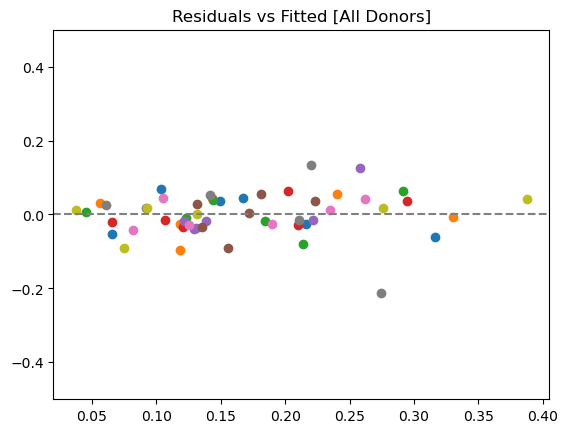

Average abs. residual:  0.042499312008650106


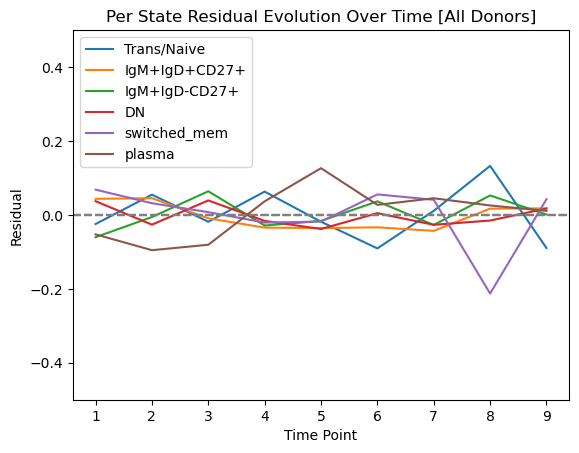

In [13]:
# residuals

N, M, T, k = eqTin(cyto, proportion=False)
timeCourse_allP = timepoint_list_allP.shape[0]
u = np.diff(timepoint_list_allP)

new = theta_allP
S1_Q = theta_to_Q(new, k, Q_template)

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) 
    epsi[(i-1),:] = pred[:,(i-1)] - N[:,i]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-.5,.5)
plt.title("Residuals vs Fitted [All Donors]")
plt.show() 

xseq = []
for i in range(1,timeCourse_allP): xseq.append(str(i))

for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = celltype_list[i]); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.title("Per State Residual Evolution Over Time [All Donors]"); plt.axhline(y=0, linestyle = '--', color = 'grey')

plt.ylim(-.5,.5)
        
print("Average abs. residual: ", np.mean(abs(epsi)))

In [15]:
pd.DataFrame(S1_Q, index=celltype_list, columns=celltype_list)

,Trans/Naive,IgM+IgD+CD27+,IgM+IgD-CD27+,DN,switched_mem,plasma
Trans/Naive,-0.0014,2.379056e-08,2.337567e-08,2.001114e-08,1.399526e-03,7.993733e-10
IgM+IgD+CD27+,0.0000,-2.678635e-01,2.100496e-01,5.519616e-07,5.781334e-02,1.810701e-10
IgM+IgD-CD27+,0.0000,1.210282e-01,-1.470133e-01,2.580752e-02,4.389561e-08,1.775454e-04
DN,0.0000,3.198617e-02,9.365821e-08,-6.728368e-02,3.529742e-02,3.420125e-09
switched_mem,0.0000,0.000000e+00,0.000000e+00,3.909206e-02,-3.909208e-02,1.718769e-08
plasma,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00


In [16]:
new = theta_allP
celltype_names = ['Trans/Naive', 'M_mem', 'IgM+IgD-CD27+','DN', 'C_mem', 'plasma']
S1_Q = theta_to_Q(new, k, Q_template)
pd.DataFrame(transMat(S1_Q, u[0]), index=celltype_names, columns=celltype_names)

,Trans/Naive,M_mem,IgM+IgD-CD27+,DN,C_mem,plasma
Trans/Naive,0.991638,0.000039,0.000011,0.000800,0.007512,7.876788e-09
M_mem,0.000000,0.332179,0.430820,0.062738,0.173934,3.294361e-04
IgM+IgD-CD27+,0.000000,0.254513,0.578771,0.097770,0.068163,7.838598e-04
DN,0.000000,0.085784,0.051110,0.689855,0.173227,2.251131e-05
C_mem,0.000000,0.011895,0.004638,0.172368,0.811098,1.515862e-06
plasma,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00


In [20]:
# transform residual vector
Y = np.array([])
X = np.empty((0,2))

for t in range(T-1):
    Y = np.append(Y,epsi[t,:], axis=0)
    time = [t+1]*len(celltype_list)
    features = np.concatenate((np.array(time).reshape(k,1),np.array(celltype_list).reshape(k,1)), axis = 1)
    X = np.append(X,features, axis = 0)

df=pd.DataFrame(X, columns=('TimePoint','State'))
df.TimePoint = df.TimePoint.astype('int64')
df = pd.get_dummies(data=df, drop_first=True)
X = df


In [21]:
X = sm.add_constant(X)
X = X.astype('float')
ls=sm.OLS(Y,X).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.125
Method:                 Least Squares   F-statistic:                   0.02186
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               1.00
Time:                        10:28:05   Log-Likelihood:                 78.974
No. Observations:                  54   AIC:                            -143.9
Df Residuals:                      47   BIC:                            -130.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0018    

In [22]:
# sojourn time
q_ii = np.diagonal(S1_Q)

pd.DataFrame({'Parameter': celltype_names, 'Holding Time': (lambda i: 1/(-q_ii[i]))(range(k))})

/tmp/ipykernel_140469/1519030099.py:4: RuntimeWarning: divide by zero encountered in divide
  pd.DataFrame({'Parameter': celltype_names, 'Holding Time': (lambda i: 1/(-q_ii[i]))(range(k))})


,Parameter,Holding Time
0,Trans/Naive,714.492768
1,M_mem,3.733245
2,IgM+IgD-CD27+,6.802105
3,DN,14.862445
4,C_mem,25.580632
5,plasma,inf


In [23]:
pd.DataFrame(np.round(transMat(S1_Q, u[0]),2))

,0,1,2,3,4,5
0,0.99,0.00,0.00,0.00,0.01,0.0
1,0.00,0.33,0.43,0.06,0.17,0.0
2,0.00,0.25,0.58,0.10,0.07,0.0
3,0.00,0.09,0.05,0.69,0.17,0.0
4,0.00,0.01,0.00,0.17,0.81,0.0
5,0.00,0.00,0.00,0.00,0.00,1.0


#### 1 CP

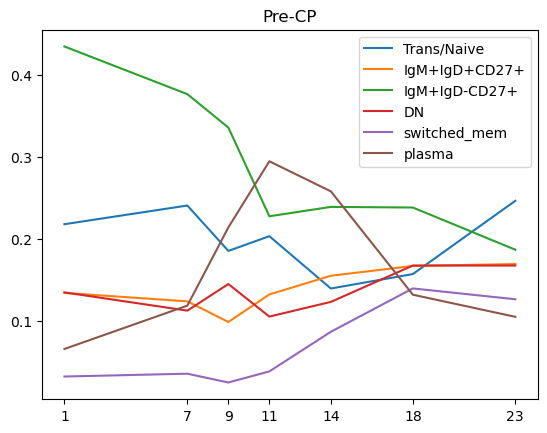

In [26]:
for i in range(6):
    plt.plot(timepoint_list[:-3],cyto[i,:-3], label = celltype_list[i])
    plt.xticks(timepoint_list[:-3])
plt.title('Pre-CP')
plt.legend()
plt.show()

In [43]:
timepoint_list_allP[:-3]

array([ 1,  7,  9, 11, 14, 18, 23])

In [ ]:
gterm = 1e-15

N, M, T, k = eqTin(cyto[:,:-3], proportion=False)


#M_donors, N_donors, T_donors, u_donors = eqTin_donors(cyto_sPos, iscount=False, proportion_col_name='value')
#optimiserArgs = {'costFunc': calc_S1_donors, 'args': (M_donors, N_donors, T_donors, k, u_donors, Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 1}

#theta_allP, optError_allP = parallel_mc_optimiser(mc_iter, numCores, n_param, genTheta, optimiserArgs = optimiserArgs, options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}, progress_bar=True)



optimiserArgs = {'costFunc': calc_S1_donors, 'args': (M, N, T, k, u[:4], Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 1}
theta_1_2, optError_1_2 = parallel_mc_optimiser(mc_iter, numCores, n_param, genTheta, optimiserArgs = optimiserArgs, options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}, progress_bar=True)


N, M, T, k = eqTin(cyto[:,-4:], proportion=False)
optimiserArgs = {'costFunc': calc_S1, 'args': (M, N, T, k, u[4:], Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 1}
theta_2_2, optError_2_2 = parallel_mc_optimiser(mc_iter, numCores, n_param, genTheta, optimiserArgs = optimiserArgs, options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}, progress_bar=True)

Optimisation progress:  [================================================] 100%
Optimisation progress:  [================================================] 100%


In [ ]:
import pickle
filename = "manuscript_results/cyto_1CP.pkl"
with open(filename, 'wb') as f:
    pickle.dump({'theta_preCP': theta_1_2, 'theta_postCP': theta_2_2, 'optError_preCP': optError_1_2, 'optError_postCP': optError_2_2}, f)

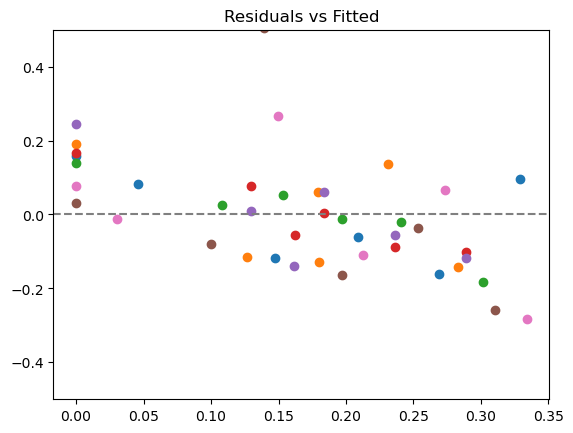

Average abs. residual:  0.11644145979705939


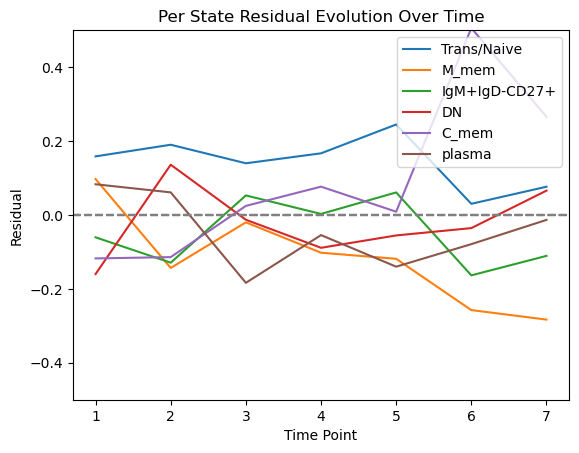

In [ ]:
# residuals
N, M, T, k = eqTin(sPos, proportion=False)

preCP = theta_1_2
postCP = theta_1_2

Q_pre = theta_to_Q(preCP, k, Q_template)
Q_post = theta_to_Q(postCP, k, Q_template)

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

# change point time index
CP = 5

# pre
for i in range(1,CP):
    S1_P = transMat(Q_pre, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) 
    epsi[(i-1),:] = N[:,i] - pred[:,(i-1)]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

# post 
for i in range(CP,T):
    S1_P = transMat(Q_post, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) 
    epsi[(i-1),:] = N[:,i] - pred[:,(i-1)]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-.5,.5)
plt.title("Residuals vs Fitted")
plt.show() 

xseq = []
for i in range(1,timeCourse): xseq.append(str(i))

for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = celltype_names[i]); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.title("Per State Residual Evolution Over Time"); plt.axhline(y=0, linestyle = '--', color = 'grey')

plt.ylim(-.5,.5)
        
print("Average abs. residual: ", np.mean(abs(epsi)))

In [ ]:
pd.DataFrame(transMat(theta_to_Q(theta_1_2, k, Q_template), u[0]), index=celltype_list, columns=celltype_list)

,Trans/Naive,IgM+IgD-CD27+,IgM+IgD+CD27+,DN,switched_mem,plasma
Trans/Naive,9.425289e-50,0.234084,0.148940,0.191475,0.104970,0.320530
IgM+IgD-CD27+,0.000000e+00,0.344508,0.219198,0.281800,0.154488,0.000006
IgM+IgD+CD27+,0.000000e+00,0.344508,0.219198,0.281800,0.154488,0.000006
DN,0.000000e+00,0.344508,0.219198,0.281800,0.154488,0.000006
switched_mem,0.000000e+00,0.344508,0.219198,0.281800,0.154488,0.000006
plasma,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
pd.DataFrame(transMat(theta_to_Q(theta_2_2, k, Q_template), u[0]), index=celltype_list, columns=celltype_list)

,Trans/Naive,IgM+IgD-CD27+,IgM+IgD+CD27+,DN,switched_mem,plasma
Trans/Naive,1.622607e-19,0.017618,0.131381,0.347295,0.486464,0.017241
IgM+IgD-CD27+,0.000000e+00,0.017875,0.133298,0.352362,0.493562,0.002903
IgM+IgD+CD27+,0.000000e+00,0.017874,0.133291,0.352342,0.493533,0.002960
DN,0.000000e+00,0.017877,0.133314,0.352404,0.493619,0.002786
switched_mem,0.000000e+00,0.017880,0.133338,0.352469,0.493710,0.002602
plasma,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
# transform residual vector
Y = np.array([])
X = np.empty((0,2))

for t in range(T-1):
    Y = np.append(Y,epsi[t,:], axis=0)
    time = [t+1]*len(state_list)
    features = np.concatenate((np.array(time).reshape(7,1),np.array(state_list).reshape(7,1)), axis = 1)
    X = np.append(X,features, axis = 0)

df=pd.DataFrame(X, columns=('TimePoint','State'))
df.TimePoint = df.TimePoint.astype('int64')
df = pd.get_dummies(data=df, drop_first=True)
X = df


In [ ]:
X = sm.add_constant(X)
X = X.astype('float')
ls=sm.OLS(Y,X).fit()
print(ls.summary())

#### Accounting for ingress

Ingress bounds &

In [ ]:
q_lb = np.zeros(n_param+1)
q_ub = np.zeros(n_param+1)

q_diag = np.zeros((k-1))

for n in range((k-1)):
    q_diag[n] = (k-1) * n
    
for n in range(n_param):
    if n in q_diag:
        q_lb[n] = -inf
        q_ub[n] = 0
    else:
        q_lb[n] = 0 
        q_ub[n] = inf
q_lb[-1] = -1
q_ub[-1] = 1

ingress_bounds = Bounds(q_lb, q_ub)

row_eq = np.zeros((((k-1),n_param+1)))

row_eq[0,0:5] = 1

for n in range(1,(k-1)):
    i = int(4*n + 1)
    j = int(4*n + 5)
    
    row_eq[n,i:j] = 1
    
ingress_con = LinearConstraint(row_eq, ub = np.zeros((k-1)), keep_feasible=True)

Baseline bounds &

In [ ]:
q_lb = np.zeros(n_param+k)
q_ub = np.zeros(n_param+k)

q_diag = np.zeros((k-1))

for n in range((k-1)):
    q_diag[n] = (k-1) * n
    
for n in range(n_param):
    if n in q_diag:
        q_lb[n] = -inf
        q_ub[n] = 0
    else:
        q_lb[n] = 0 
        q_ub[n] = inf
q_lb[-k:] = -1
q_ub[-k:] = 1

base_bounds = Bounds(q_lb, q_ub)

row_eq = np.zeros((((k-1),n_param+k)))

row_eq[0,0:5] = 1

for n in range(1,(k-1)):
    i = int(4*n + 1)
    j = int(4*n + 5)
    
    row_eq[n,i:j] = 1
    
base_con = LinearConstraint(row_eq, ub = np.zeros((k-1)), keep_feasible=True)

In [ ]:
optimiserArgs = {'costFunc': calc_S1_b0, 'args': (M, N, T, k, u, Q_template), 'bounds': ingress_bounds, 'constraints': ingress_con, 'sampRange_ub': 1}

theta_ingress, optError_ingress = parallel_mc_optimiser(mc_iter, numCores, n_param, genTheta_ingress, optimiserArgs = optimiserArgs, options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}, progress_bar=True)

In [ ]:
# residuals
new = theta_ingress[:-1]
ing = np.append(new[-1],np.zeros(k-1))
S1_Q = theta_to_Q(new, k, Q_template)

epsi = np.zeros((T-1,(k)))
pred = np.zeros(((k),T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) + ing * (1-np.exp(-i))
    epsi[(i-1),:] = N[:,i] - pred[:,(i-1)]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])


plt.ylim(-.5,.5)
plt.title("Residuals vs Fitted")
plt.show() 

xseq = []
for i in range(1,timeCourse): xseq.append(str(i))

for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = ('State' + str(i+1))); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.title("Per State Residual Evolution Over Time"); plt.axhline(y=0, linestyle = '--', color = 'grey')

plt.ylim(-.5,.5)
        
print("Average abs. residual: ", np.mean(abs(epsi)))

In [ ]:
optimiserArgs = {'costFunc': calc_S1_baseline, 'args': (M, N, T, k, u, Q_template), 'bounds': base_bounds, 'constraints': base_con, 'sampRange_ub': 1}

theta_base, optError_base = parallel_mc_optimiser(mc_iter, numCores, n_param, genTheta_baseline, optimiserArgs = optimiserArgs, options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}, progress_bar=True)

In [ ]:
# residuals
new = theta_base[:-k]
ing = theta_base[-k:]
S1_Q = theta_to_Q(new, k, Q_template)

epsi = np.zeros((T-1,(k-1)))
pred = np.zeros(((k-1),T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P[:,:(k-1)].transpose(),N[:,(i-1)]) + ing[:-1] 
    epsi[(i-1),:] = M[:,i] - pred[:,(i-1)]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])


plt.ylim(-.5,.5)
plt.title("Residuals vs Fitted")
plt.show() 

xseq = []
for i in range(1,timeCourse): xseq.append(str(i))

for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = ('State' + str(i+1))); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.title("Per State Residual Evolution Over Time"); plt.axhline(y=0, linestyle = '--', color = 'grey')

plt.ylim(-.5,.5)
        
print("Average abs. residual: ", np.mean(abs(epsi)))

In [ ]:
S1_Q = theta_to_Q(theta_base[:-k],u[0], Q_template)
pd.DataFrame(transMat(S1_Q, u[0]))

In [ ]:
# residuals
S1_Q = theta_to_Q(theta, k, Q_template)
Est_N = pd.DataFrame({'d1': N[:,0]})

for i in range(1,len(timepoint_list)):
    S1_P = transMat(S1_Q, u[i-1])
    
    N_est = Est_N.to_numpy()
    
    # estimate proportions
    prop = np.matmul(S1_P.transpose(),N_est[:,(i-1)]) 
    
    # save out
    day = 'd' + str(timepoint_list[i])
    Est_N[day] = prop

    
Est_N

In [ ]:
true_N = pd.DataFrame(N)

for i in range(k):
    plt.plot(true_N.iloc[i,:], label = 'true_N')
    plt.plot(Est_N.iloc[i,:], label = 'est')
    plt.title('State ' + str(i+1) + ' Proportions')
    plt.legend()
    plt.show()